# Data Mining Project : Molecular Properties Prediction

* **Superviseurs: Prof. Alexandros Kalousis, Assit. Victor Reyes Martin, Assit. Yoan Boget**
* **Etudiants: VANSON Nathan, PAPA David**

*Remarques : Nous ne présentons ici que les résultats obtenus sur l'ensemble de modèles que nous avons testé sur les différentes données. Pour plus de détails sur les modèles et les résultats obtenus, veuillez vous référer au rapport de projet disponible dans l'archive du projet.*

---

## Librairies & Setup

In [35]:
# Libraries.
import os
import torch
import joblib
import matplotlib

# Modules.
from mpp.utils.data_processing import DataProcessor
from mpp.utils.visualization import plot_correlation_matrix, plot_results, plot_training_process, plot_multiple_training_processes, plot_feature_correlations, plot_prediction
from mpp.models.neural_network import NeuralNetworkModel
from mpp.models.random_forest import RandomForestModel
from mpp.models.gradient_boosting import GradientBoostingModel
from mpp.models.knn import BaselineKNN
from mpp.tuning.tune import HyperparameterTuning

# Warning.
import warnings
warnings.filterwarnings('ignore')

# Make figures appear inline.
matplotlib.rcParams['figure.figsize'] = (15, 8)
%matplotlib inline

# Notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Device : use cuda if available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [5]:
# Verify if the model exists.
def model_exists(model_path):
    return os.path.exists(model_path)

---
## Data Preprocessing

In [32]:
# Load the data.
processor = DataProcessor("data/data.csv")
data = processor.load_data()
data.head()

,SMILES,pIC50,num_atoms,logP
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,25,4.1591
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,36,3.6743
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,23,1.5361
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,22,0.9510
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,21,3.2130


In [7]:
# Extract features.
data_with_features = processor.extract_features()
data_with_features.head()

,pIC50,num_atoms,logP,MolWt,NumAtoms,NumBonds,NumC,NumO,NumN,NumCl,NumF,NumBr,NumI
0,4.26,25,4.1591,367.455,25,28,0,2,1,0,0,0,0
1,4.34,36,3.6743,506.434,36,40,2,4,0,0,1,0,0
2,4.53,23,1.5361,317.389,23,25,10,3,1,0,0,0,0
3,4.56,22,0.9510,301.394,22,24,9,1,3,0,0,0,0
4,4.59,21,3.2130,294.383,21,23,2,0,2,0,0,0,0


In [8]:
# Split the data.
X_train, X_test, y_train_pic50, y_test_pic50, y_train_logP, y_test_logP = processor.split_data()

# Display the training data (you can change with X_test, y_test_pic50, y_test_logP).
X_train.head()

,num_atoms,MolWt,NumAtoms,NumBonds,NumC,NumO,NumN,NumCl,NumF,NumBr,NumI
6307,20,278.304,20,20,9,5,0,0,0,0,0
4342,20,296.392,20,21,8,3,2,0,0,0,0
1068,24,344.806,24,26,9,1,3,1,0,0,0
13003,50,701.994,50,52,33,6,5,0,0,0,0
4800,17,225.255,17,19,1,0,1,0,0,0,0


---
## Correlation matrix

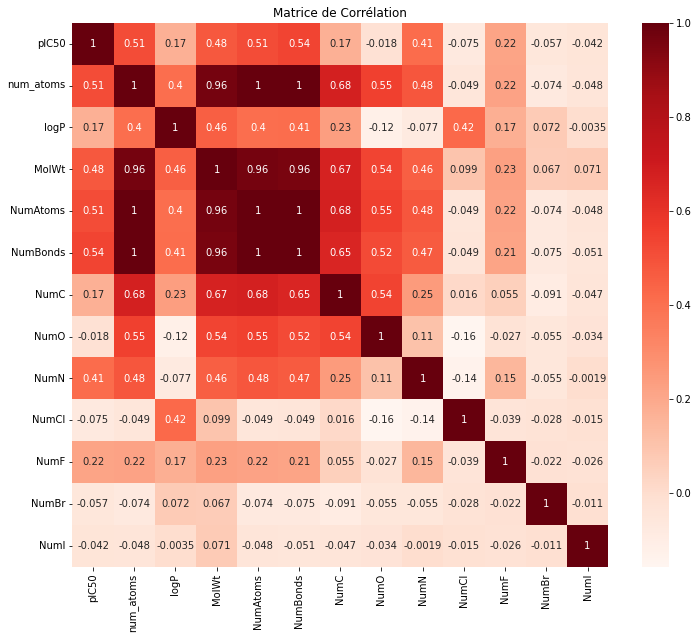

In [9]:
# Feature visualization
plot_correlation_matrix(data_with_features)

### Displaying correlations

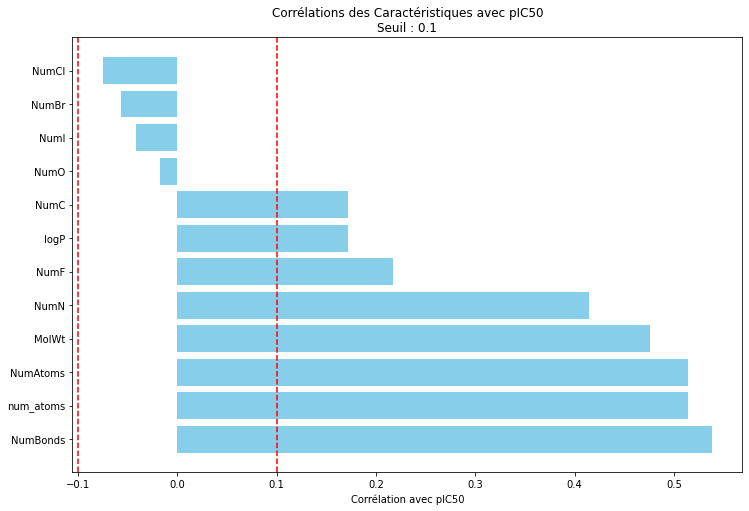

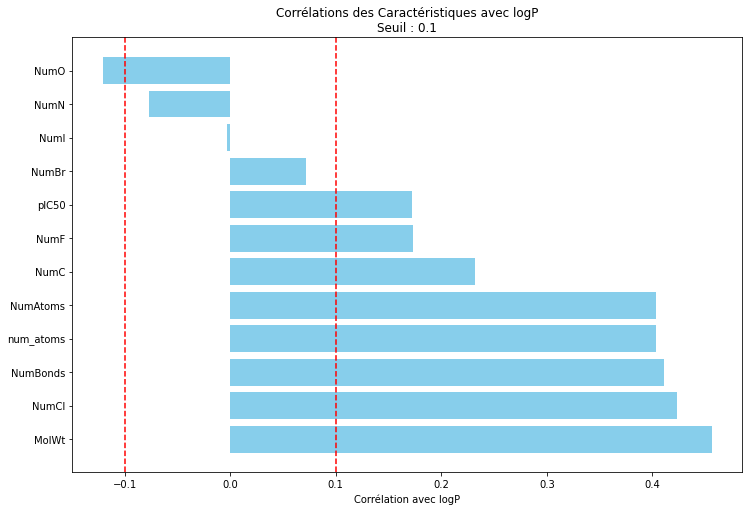

In [10]:
# Plot feature correlations with pIC50 and logP.
plot_feature_correlations(data_with_features, 'pIC50', output_path="feature_correlations_pic50.png")
plot_feature_correlations(data_with_features, 'logP', output_path="feature_correlations_logP.png")

---
## Neural Networks (NN) Models

* ### pic50

Loaded existing pIC50 params.

Best trial : {'lr': 0.0021666814143117574, 'epochs': 87, 'batch_size': 121, 'hidden_layers': 3, 'hidden_size_0': 54, 'hidden_size_1': 73, 'hidden_size_2': 115, 'patience': 11}



Neural Network Model MSE for pIC50: 0.9562442953853061
Neural Network Model RMSE for pIC50: 0.9778774439495505
Neural Network Model MAE for pIC50: 0.36316908435638434
Neural Network Model MAPE for pIC50: 485606150919977.1


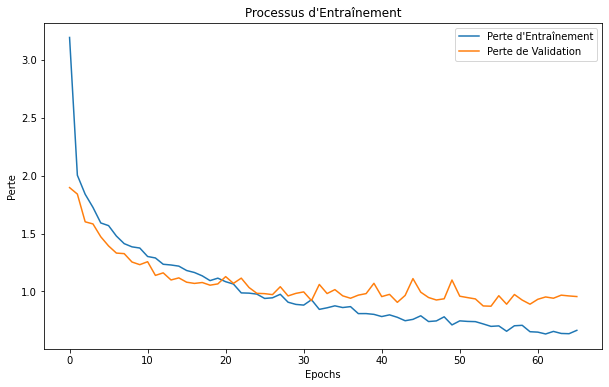

In [11]:
# Hyperparameter tuning for Neural Network (pIC50)
if model_exists('params/nn_best_params_pic50.pkl'):
    print("Loaded existing pIC50 params.\n")
    loaded_best_params_pic50 = joblib.load('params/nn_best_params_pic50.pkl')
    print(f"Best trial : {loaded_best_params_pic50}")
    nn_model_pic50 = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[loaded_best_params_pic50[f"hidden_size_{i}"] for i in range(loaded_best_params_pic50["hidden_layers"])],
        lr=loaded_best_params_pic50["lr"],
        epochs=loaded_best_params_pic50["epochs"],
        batch_size=loaded_best_params_pic50["batch_size"],
        patience=loaded_best_params_pic50["patience"]
    )
    training_loss_pic50, validation_loss_pic50 = nn_model_pic50.train(X_train, y_train_pic50, X_test, y_test_pic50)
    nn_mse_pIC50, nn_rmse_pIC50, nn_mae_pIC50, nn_mape_pIC50 = nn_model_pic50.evaluate(X_test, y_test_pic50)
    print(f"Neural Network Model MSE for pIC50: {nn_mse_pIC50}")
    print(f"Neural Network Model RMSE for pIC50: {nn_rmse_pIC50}")
    print(f"Neural Network Model MAE for pIC50: {nn_mae_pIC50}")
    print(f"Neural Network Model MAPE for pIC50: {nn_mape_pIC50}")
    plot_training_process(training_loss_pic50, validation_loss_pic50, output_path="training_process_pic50.png")
    
else:
    tuner_pic50 = HyperparameterTuning(X_train, y_train_pic50, "Neural Network")
    best_params_pic50 = tuner_pic50.tune(n_trials=50)
    joblib.dump(best_params_pic50, 'params/nn_best_params_pic50.pkl')
    nn_model_pic50 = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[best_params_pic50[f"hidden_size_{i}"] for i in range(best_params_pic50["hidden_layers"])],
        lr=best_params_pic50["lr"],
        epochs=best_params_pic50["epochs"],
        batch_size=best_params_pic50["batch_size"],
        patience=best_params_pic50["patience"]
    )
    training_loss_pic50, validation_loss_pic50 = nn_model_pic50.train(X_train, y_train_pic50, X_test, y_test_pic50)
    nn_mse_pIC50, nn_rmse_pIC50, nn_mae_pIC50, nn_mape_pIC50 = nn_model_pic50.evaluate(X_test, y_test_pic50)
    print(f"Neural Network Model MSE for pIC50: {nn_mse_pIC50}")
    print(f"Neural Network Model RMSE for pIC50: {nn_rmse_pIC50}")
    print(f"Neural Network Model MAE for pIC50: {nn_mae_pIC50}")
    print(f"Neural Network Model MAPE for pIC50: {nn_mape_pIC50}")
    plot_training_process(training_loss_pic50, validation_loss_pic50, output_path="training_process_pic50.png")


* ### logP

Loaded existing logP params.

Best trial : {'lr': 0.0056863426884850195, 'epochs': 99, 'batch_size': 96, 'hidden_layers': 3, 'hidden_size_0': 135, 'hidden_size_1': 183, 'hidden_size_2': 164, 'patience': 16}



Neural Network Model MSE for logP: 0.39459852818849356
Neural Network Model RMSE for logP: 0.6281707794768024
Neural Network Model MAE for logP: 0.47355548888556187
Neural Network Model MAPE for logP: 0.6107911764871407


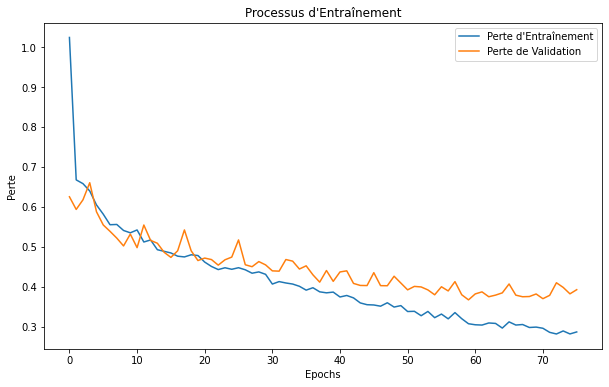

In [12]:
# Hyperparameter tuning for Neural Network (logP)
if model_exists('params/nn_best_params_logP.pkl'):
    print("Loaded existing logP params.\n")
    loaded_best_params_logP = joblib.load('params/nn_best_params_logP.pkl')
    print(f"Best trial : {loaded_best_params_logP}")
    nn_model_logP = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[loaded_best_params_logP[f"hidden_size_{i}"] for i in range(loaded_best_params_logP["hidden_layers"])],
        lr=loaded_best_params_logP["lr"],
        epochs=loaded_best_params_logP["epochs"],
        batch_size=loaded_best_params_logP["batch_size"],
        patience=loaded_best_params_logP["patience"]
    )
    training_loss_logP, validation_loss_logP = nn_model_logP.train(X_train, y_train_logP, X_test, y_test_logP)
    nn_mse_logP, nn_rmse_logP, nn_mae_logP, nn_mape_logP = nn_model_logP.evaluate(X_test, y_test_logP)
    print(f"Neural Network Model MSE for logP: {nn_mse_logP}")
    print(f"Neural Network Model RMSE for logP: {nn_rmse_logP}")
    print(f"Neural Network Model MAE for logP: {nn_mae_logP}")
    print(f"Neural Network Model MAPE for logP: {nn_mape_logP}")
    plot_training_process(training_loss_logP, validation_loss_logP, output_path="training_process_logP.png")
    
else:
    tuner_logP = HyperparameterTuning(X_train, y_train_logP, "Neural Network")
    best_params_logP = tuner_logP.tune(n_trials=50)
    joblib.dump(best_params_logP, 'params/nn_best_params_logP.pkl')
    nn_model_logP = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[best_params_logP[f"hidden_size_{i}"] for i in range(best_params_logP["hidden_layers"])],
        lr=best_params_logP["lr"],
        epochs=best_params_logP["epochs"],
        batch_size=best_params_logP["batch_size"],
        patience=best_params_logP["patience"]
    )
    training_loss_logP, validation_loss_logP = nn_model_logP.train(X_train, y_train_logP, X_test, y_test_logP)
    torch.save(nn_model_logP.model.state_dict(), 'models/nn_model_logP.pth')
    nn_mse_logP, nn_rmse_logP, nn_mae_logP, nn_mape_logP = nn_model_logP.evaluate(X_test, y_test_logP)
    print(f"Neural Network Model MSE for logP: {nn_mse_logP}")
    print(f"Neural Network Model RMSE for logP: {nn_rmse_logP}")
    print(f"Neural Network Model MAE for logP: {nn_mae_logP}")
    print(f"Neural Network Model MAPE for logP: {nn_mape_logP}")
    plot_training_process(training_loss_logP, validation_loss_logP, output_path="training_process_logP.png")


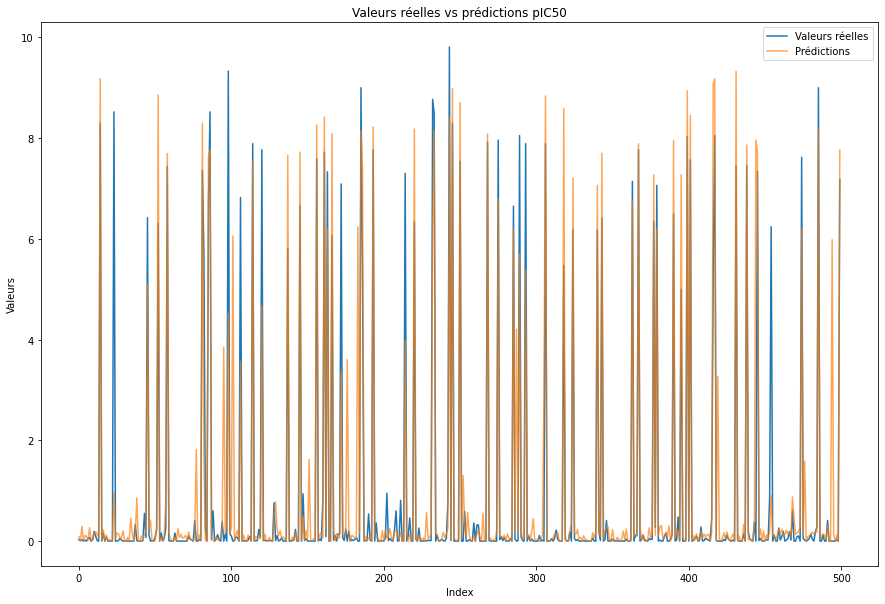

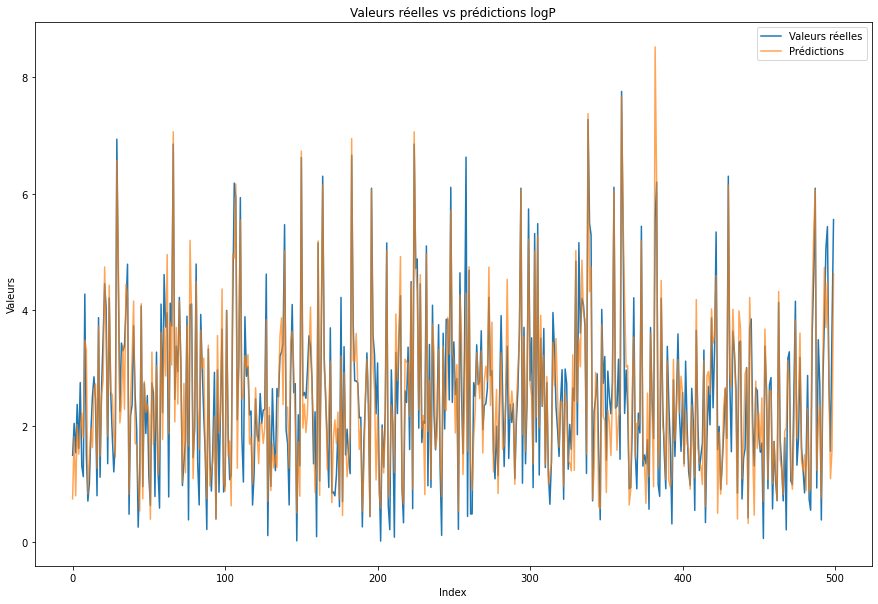

In [40]:
#visuel des 500 premiers echantillons de tests (pour mieux voir)
valeurs_pic50, valeurs_pic50_pred = nn_model_pic50.prediction(X_test, y_test_pic50)

#pIC50 positif donc si <0 -> on met à 0
for i,e in enumerate(valeurs_pic50_pred):
    if e < 0:
        valeurs_pic50_pred[i] = 0
        
plot_prediction(valeurs_pic50[:500], valeurs_pic50_pred[:500], "Valeurs réelles vs prédictions pIC50")

valeurs_logP, valeurs_logP_pred = nn_model_logP.prediction(X_test, y_test_logP)
plot_prediction(valeurs_logP[:500], valeurs_logP_pred[:500], "Valeurs réelles vs prédictions logP")

---
## K-nearest neighbors (KNN) -> **BASELINE**

* ### pic50

In [11]:
# Hyperparameter tuning and model training for KNN (pIC50)
if model_exists('params/knn_best_params_pic50.pkl'):
    print("Loaded existing pIC50 KNN params.\n")
    loaded_best_params_pic50_knn = joblib.load('params/knn_best_params_pic50.pkl')
    print(f"Best trial : {loaded_best_params_pic50_knn}")
    knn_model_pic50 = BaselineKNN(n_neighbors=loaded_best_params_pic50_knn["n_neighbors"])
    knn_model_pic50.train(X_train, y_train_pic50)
    knn_mse_pic50, knn_rmse_pic50, knn_mae_pic50, knn_mape_pic50 = knn_model_pic50.evaluate(X_test, y_test_pic50)
    print(f"KNN Model MSE for pIC50: {knn_mse_pic50}")
    print(f"KNN Model RMSE for pIC50: {knn_rmse_pic50}")
    print(f"KNN Model MAE for pIC50: {knn_mae_pic50}")
    print(f"KNN Model MAPE for pIC50: {knn_mape_pic50}")
    
else:
    tuner_pic50_knn = HyperparameterTuning(X_train, y_train_pic50, "KNN")
    best_params_pic50_knn = tuner_pic50_knn.tune(n_trials=50)
    joblib.dump(best_params_pic50_knn, 'params/knn_best_params_pic50.pkl')
    knn_model_pic50 = BaselineKNN(n_neighbors=best_params_pic50_knn["n_neighbors"])
    knn_model_pic50.train(X_train, y_train_pic50)
    knn_mse_pic50, knn_rmse_pic50, knn_mae_pic50, knn_mape_pic50 = knn_model_pic50.evaluate(X_test, y_test_pic50)
    print(f"KNN Model MSE for pIC50: {knn_mse_pic50}")
    print(f"KNN Model RMSE for pIC50: {knn_rmse_pic50}")
    print(f"KNN Model MAE for pIC50: {knn_mae_pic50}")
    print(f"KNN Model MAPE for pIC50: {knn_mape_pic50}")


Loaded existing pIC50 KNN params.

Best trial : {'n_neighbors': 3}
KNN Model MSE for pIC50: 1.7438015070921988
KNN Model RMSE for pIC50: 1.320530767188784
KNN Model MAE for pIC50: 0.46635195035460997
KNN Model MAPE for pIC50: 738836879027939.8


* ### logP

In [12]:
# Hyperparameter tuning and model training for KNN (logP)
if model_exists('params/knn_best_params_logP.pkl'):
    print("Loaded existing logP KNN params.\n")
    loaded_best_params_logP_knn = joblib.load('params/knn_best_params_logP.pkl')
    print(f"Best trial : {loaded_best_params_logP_knn}")
    knn_model_logP = BaselineKNN(n_neighbors=loaded_best_params_logP_knn["n_neighbors"])
    knn_model_logP.train(X_train, y_train_logP)
    knn_mse_logP, knn_rmse_logP, knn_mae_logP, knn_mape_logP = knn_model_logP.evaluate(X_test, y_test_logP)
    print(f"KNN Model MSE for logP: {knn_mse_logP}")
    print(f"KNN Model RMSE for logP: {knn_rmse_logP}")
    print(f"KNN Model MAE for logP: {knn_mae_logP}")
    print(f"KNN Model MAPE for logP: {knn_mape_logP}")
    
else:
    tuner_logP_knn = HyperparameterTuning(X_train, y_train_logP, "KNN")
    best_params_logP_knn = tuner_logP_knn.tune(n_trials=50)
    joblib.dump(best_params_logP_knn, 'params/knn_best_params_logP.pkl')
    knn_model_logP = BaselineKNN(n_neighbors=best_params_logP_knn["n_neighbors"])
    knn_model_logP.train(X_train, y_train_logP)
    knn_mse_logP, knn_rmse_logP, knn_mae_logP, knn_mape_logP = knn_model_logP.evaluate(X_test, y_test_logP)
    print(f"KNN Model MSE for logP: {knn_mse_logP}")
    print(f"KNN Model RMSE for logP: {knn_rmse_logP}")
    print(f"KNN Model MAE for logP: {knn_mae_logP}")
    print(f"KNN Model MAPE for logP: {knn_mape_logP}")

Loaded existing logP KNN params.

Best trial : {'n_neighbors': 4}
KNN Model MSE for logP: 0.7275619698566268
KNN Model RMSE for logP: 0.8529724320613339
KNN Model MAE for logP: 0.6083418774933512
KNN Model MAPE for logP: 0.8207649488964477


---
## Random Forest Models

* ### pic50

In [13]:
# Hyperparameter tuning and model training for Random Forest (pIC50)
if model_exists('params/rf_best_params_pic50.pkl'):
    print("Loaded existing pIC50 Random Forest params.\n")
    loaded_best_params_pic50_rf = joblib.load('params/rf_best_params_pic50.pkl')
    print(f"Best trial : {loaded_best_params_pic50_rf}")
    rf_model_pic50 = RandomForestModel(n_estimators=loaded_best_params_pic50_rf["n_estimators"], 
                                       max_depth=loaded_best_params_pic50_rf["max_depth"])
    rf_model_pic50.train(X_train, y_train_pic50)
    rf_mse_pic50, rf_rmse_pic50, rf_mae_pic50, rf_mape_pic50 = rf_model_pic50.evaluate(X_test, y_test_pic50)
    print(f"Random Forest Model MSE for pIC50: {rf_mse_pic50}")
    print(f"Random Forest Model RMSE for pIC50: {rf_rmse_pic50}")
    print(f"Random Forest Model MAE for pIC50: {rf_mae_pic50}")
    print(f"Random Forest Model MAPE for pIC50: {rf_mape_pic50}")
    
else:
    tuner_pic50_rf = HyperparameterTuning(X_train, y_train_pic50, "Random Forest")
    best_params_pic50_rf = tuner_pic50_rf.tune(n_trials=50)
    joblib.dump(best_params_pic50_rf, 'params/rf_best_params_pic50.pkl')
    rf_model_pic50 = RandomForestModel(n_estimators=best_params_pic50_rf["n_estimators"], 
                                       max_depth=best_params_pic50_rf["max_depth"])
    rf_model_pic50.train(X_train, y_train_pic50)
    rf_mse_pic50, rf_rmse_pic50, rf_mae_pic50, rf_mape_pic50 = rf_model_pic50.evaluate(X_test, y_test_pic50)
    print(f"Random Forest Model MSE for pIC50: {rf_mse_pic50}")
    print(f"Random Forest Model RMSE for pIC50: {rf_rmse_pic50}")
    print(f"Random Forest Model MAE for pIC50: {rf_mae_pic50}")
    print(f"Random Forest Model MAPE for pIC50: {rf_mape_pic50}")


Loaded existing pIC50 Random Forest params.

Best trial : {'n_estimators': 192, 'max_depth': 27}
Random Forest Model MSE for pIC50: 0.9798854727707568
Random Forest Model RMSE for pIC50: 0.9898916469850408
Random Forest Model MAE for pIC50: 0.35472056346818887
Random Forest Model MAPE for pIC50: 508822473964500.94


* ### logP

In [14]:
# Hyperparameter tuning and model training for Random Forest (logP)
if model_exists('params/rf_best_params_logP.pkl'):
    print("Loaded existing logP Random Forest params.\n")
    loaded_best_params_logP_rf = joblib.load('params/rf_best_params_logP.pkl')
    print(f"Best trial : {loaded_best_params_logP_rf}")
    rf_model_logP = RandomForestModel(n_estimators=loaded_best_params_logP_rf["n_estimators"], max_depth=loaded_best_params_logP_rf["max_depth"])
    rf_model_logP.train(X_train, y_train_logP)
    rf_mse_logP, rf_rmse_logP, rf_mae_logP, rf_mape_logP = rf_model_logP.evaluate(X_test, y_test_logP)
    print(f"Random Forest Model MSE for logP: {rf_mse_logP}")
    print(f"Random Forest Model RMSE for logP: {rf_rmse_logP}")
    print(f"Random Forest Model MAE for logP: {rf_mae_logP}")
    print(f"Random Forest Model MAPE for logP: {rf_mape_logP}")
    
else:
    tuner_logP_rf = HyperparameterTuning(X_train, y_train_logP, "Random Forest")
    best_params_logP_rf = tuner_logP_rf.tune(n_trials=50)
    joblib.dump(best_params_logP_rf, 'params/rf_best_params_logP.pkl')
    rf_model_logP = RandomForestModel(n_estimators=best_params_logP_rf["n_estimators"], max_depth=best_params_logP_rf["max_depth"])
    rf_model_logP.train(X_train, y_train_logP)
    rf_mse_logP, rf_rmse_logP, rf_mae_logP, rf_mape_logP = rf_model_logP.evaluate(X_test, y_test_logP)
    print(f"Random Forest Model MSE for logP: {rf_mse_logP}")
    print(f"Random Forest Model RMSE for logP: {rf_rmse_logP}")
    print(f"Random Forest Model MAE for logP: {rf_mae_logP}")
    print(f"Random Forest Model MAPE for logP: {rf_mape_logP}")


Loaded existing logP Random Forest params.

Best trial : {'n_estimators': 127, 'max_depth': 24}
Random Forest Model MSE for logP: 0.43914277439082716
Random Forest Model RMSE for logP: 0.6626784849312879
Random Forest Model MAE for logP: 0.45524573318064293
Random Forest Model MAPE for logP: 0.6210494245195


---
## Gradient Boosting Models

* ### pic50

In [15]:
# Hyperparameter tuning and model training for Gradient Boosting (pIC50)
if model_exists('params/gb_best_params_pic50.pkl'):
    print("Loaded existing pIC50 Gradient Boosting params.\n")
    loaded_best_params_pic50_gb = joblib.load('params/gb_best_params_pic50.pkl')
    print(f"Best trial : {loaded_best_params_pic50_gb}")
    gb_model_pic50 = GradientBoostingModel(n_estimators=loaded_best_params_pic50_gb["n_estimators"], 
                                           learning_rate=loaded_best_params_pic50_gb["learning_rate"], 
                                           max_depth=loaded_best_params_pic50_gb["max_depth"])
    gb_model_pic50.train(X_train, y_train_pic50)
    gb_mse_pIC50, gb_rmse_pIC50, gb_mae_pIC50, gb_mape_pIC50 = gb_model_pic50.evaluate(X_test, y_test_pic50)
    print(f"Gradient Boosting Model MSE for pIC50: {gb_mse_pIC50}")
    print(f"Gradient Boosting Model RMSE for pIC50: {gb_rmse_pIC50}")
    print(f"Gradient Boosting Model MAE for pIC50: {gb_mae_pIC50}")
    print(f"Gradient Boosting Model MAPE for pIC50: {gb_mape_pIC50}")
    
else:
    tuner_pic50_gb = HyperparameterTuning(X_train, y_train_pic50, "Gradient Boosting")
    best_params_pic50_gb = tuner_pic50_gb.tune(n_trials=50)
    joblib.dump(best_params_pic50_gb, 'params/gb_best_params_pic50.pkl')
    gb_model_pic50 = GradientBoostingModel(n_estimators=best_params_pic50_gb["n_estimators"], 
                                           learning_rate=best_params_pic50_gb["learning_rate"], 
                                           max_depth=best_params_pic50_gb["max_depth"])
    gb_model_pic50.train(X_train, y_train_pic50)
    gb_mse_pIC50, gb_rmse_pIC50, gb_mae_pIC50, gb_mape_pIC50 = gb_model_pic50.evaluate(X_test, y_test_pic50)
    print(f"Gradient Boosting Model MSE for pIC50: {gb_mse_pIC50}")
    print(f"Gradient Boosting Model RMSE for pIC50: {gb_rmse_pIC50}")
    print(f"Gradient Boosting Model MAE for pIC50: {gb_mae_pIC50}")
    print(f"Gradient Boosting Model MAPE for pIC50: {gb_mape_pIC50}")


Loaded existing pIC50 Gradient Boosting params.

Best trial : {'n_estimators': 173, 'learning_rate': 0.020746793365614725, 'max_depth': 10}
Gradient Boosting Model MSE for pIC50: 1.0818845941895645
Gradient Boosting Model RMSE for pIC50: 1.0401368151303771
Gradient Boosting Model MAE for pIC50: 0.3752806575285883
Gradient Boosting Model MAPE for pIC50: 533192775183279.3


* ### logP

In [16]:
# Hyperparameter tuning and model training for Gradient Boosting (logP)
if model_exists('params/gb_best_params_logP.pkl'):
    print("Loaded existing logP Gradient Boosting params.\n")
    loaded_best_params_logP_gb = joblib.load('params/gb_best_params_logP.pkl')
    print(f"Best trial : {loaded_best_params_logP_gb}")
    gb_model_logP = GradientBoostingModel(n_estimators=loaded_best_params_logP_gb["n_estimators"], 
                                          learning_rate=loaded_best_params_logP_gb["learning_rate"], 
                                          max_depth=loaded_best_params_logP_gb["max_depth"])
    gb_model_logP.train(X_train, y_train_logP)
    gb_mse_logP, gb_rmse_logP, gb_mae_logP, gb_mape_logP = gb_model_logP.evaluate(X_test, y_test_logP)
    print(f"Gradient Boosting Model MSE for logP: {gb_mse_logP}")
    print(f"Gradient Boosting Model RMSE for logP: {gb_rmse_logP}")
    print(f"Gradient Boosting Model MAE for logP: {gb_mae_logP}")
    print(f"Gradient Boosting Model MAPE for logP: {gb_mape_logP}")
    
else:
    tuner_logP_gb = HyperparameterTuning(X_train, y_train_logP, "Gradient Boosting")
    best_params_logP_gb = tuner_logP_gb.tune(n_trials=50)
    joblib.dump(best_params_logP_gb, 'params/gb_best_params_logP.pkl')
    gb_model_logP = GradientBoostingModel(n_estimators=best_params_logP_gb["n_estimators"], 
                                          learning_rate=best_params_logP_gb["learning_rate"], 
                                          max_depth=best_params_logP_gb["max_depth"])
    gb_model_logP.train(X_train, y_train_logP)
    gb_mse_logP, gb_rmse_logP, gb_mae_logP, gb_mape_logP = gb_model_logP.evaluate(X_test, y_test_logP)
    print(f"Gradient Boosting Model MSE for logP: {gb_mse_logP}")
    print(f"Gradient Boosting Model RMSE for logP: {gb_rmse_logP}")
    print(f"Gradient Boosting Model MAE for logP: {gb_mae_logP}")
    print(f"Gradient Boosting Model MAPE for logP: {gb_mape_logP}")


Loaded existing logP Gradient Boosting params.

Best trial : {'n_estimators': 155, 'learning_rate': 0.057744771357231404, 'max_depth': 10}
Gradient Boosting Model MSE for logP: 0.43245539392212873
Gradient Boosting Model RMSE for logP: 0.6576134076508239
Gradient Boosting Model MAE for logP: 0.46994141483196866
Gradient Boosting Model MAPE for logP: 0.667383441124664


---
## Dictionaries of error calculations

* ### pic50

In [17]:
# Results visualization for pIC50.
results_pic50_mse = {
    "Neural Network": nn_mse_pIC50,
    "KNN": knn_mse_pic50,
    "Random Forest": rf_mse_pic50,
    "Gradient Boosting": gb_mse_pIC50
}

results_pic50_rmse = {
    "Neural Network": nn_rmse_pIC50,
    "KNN": knn_rmse_pic50,
    "Random Forest": rf_rmse_pic50,
    "Gradient Boosting": gb_rmse_pIC50
}

results_pic50_mae = {
    "Neural Network": nn_mae_pIC50,
    "KNN": knn_mae_pic50,
    "Random Forest": rf_mae_pic50,
    "Gradient Boosting": gb_mae_pIC50
}

results_pic50_mape = {
    "Neural Network": nn_mae_pIC50,
    "KNN": knn_mape_pic50,
    "Random Forest": rf_mape_pic50,
    "Gradient Boosting": gb_mape_pIC50
}

* ### logP

In [18]:
# Results visualization for logP.
results_logP_mse = {
    "Neural Network": nn_mse_logP,
    "KNN": knn_mse_logP,
    "Random Forest": rf_mse_logP,
    "Gradient Boosting": gb_mse_logP
}

results_logP_rmse = {
    "Neural Network": nn_rmse_logP,
    "KNN": knn_rmse_logP,
    "Random Forest": rf_rmse_logP,
    "Gradient Boosting": gb_rmse_logP
}

results_logP_mae = {
    "Neural Network": nn_mae_logP,
    "KNN": knn_mae_logP,
    "Random Forest": rf_mae_logP,
    "Gradient Boosting": gb_mae_logP
}

results_logP_mape = {
    "Neural Network": nn_mape_logP,
    "KNN": knn_mape_logP,
    "Random Forest": rf_mape_logP,
    "Gradient Boosting": gb_mape_logP
}

## Results display

* ### Mean Squared Error (MSE)

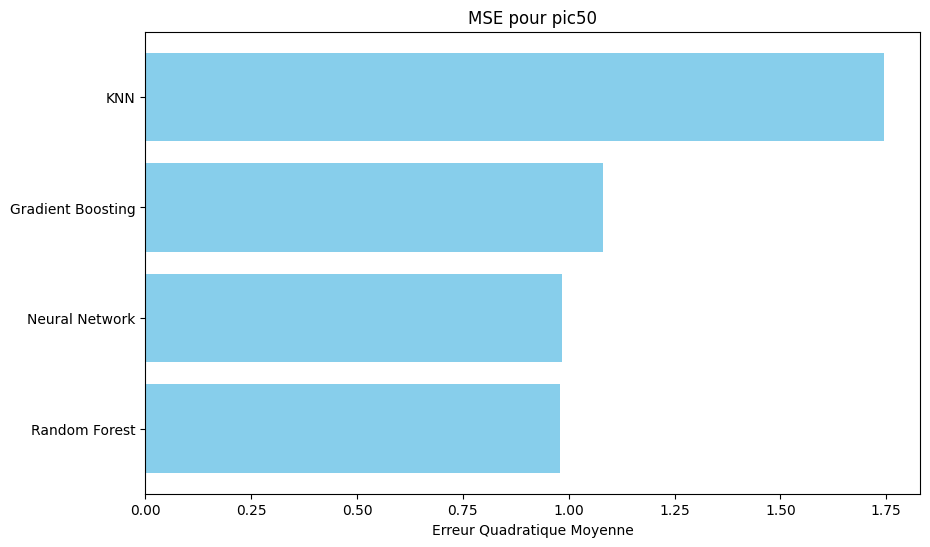

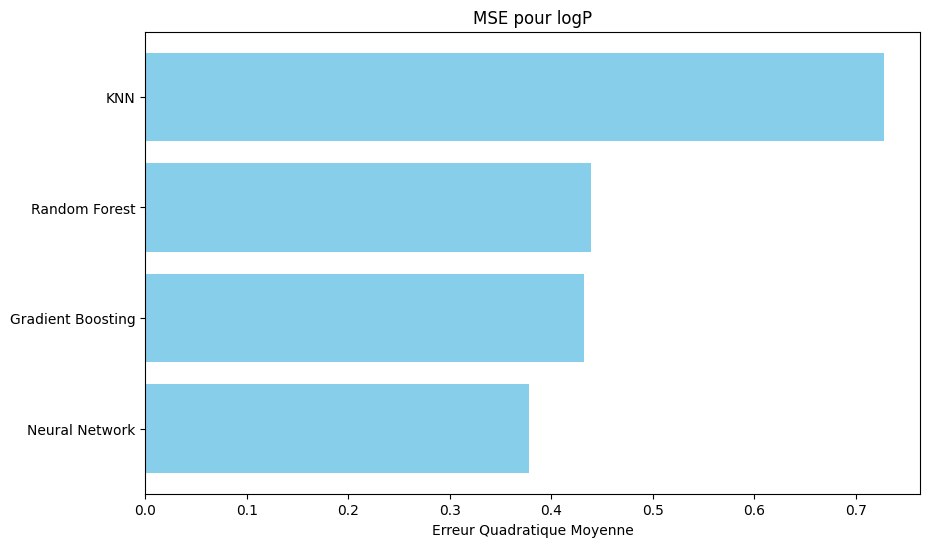

In [19]:
# Results visualization for mse pIC50, logP.
plot_results(results_pic50_mse, "MSE pour pic50", "Erreur Quadratique Moyenne")
plot_results(results_logP_mse, "MSE pour logP", "Erreur Quadratique Moyenne")

* ### Root Mean Squared Error (RMSE)

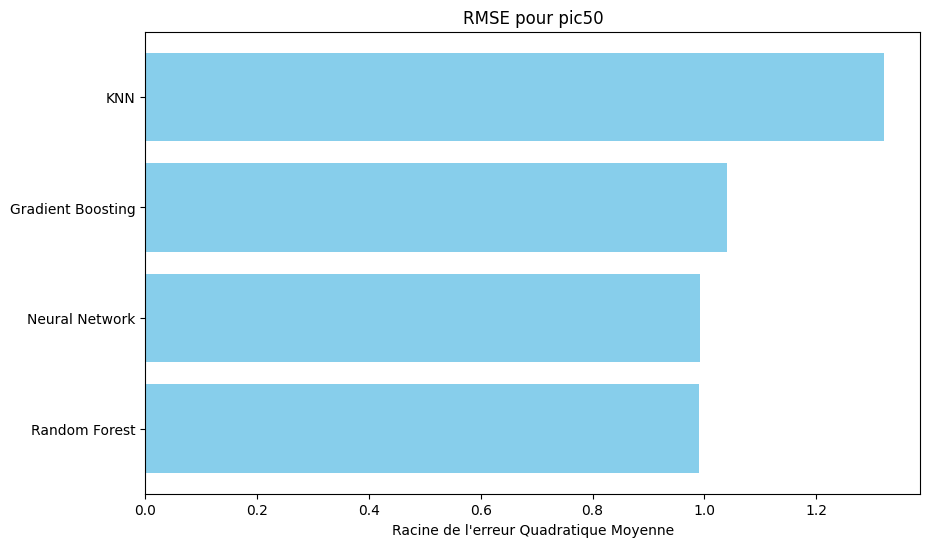

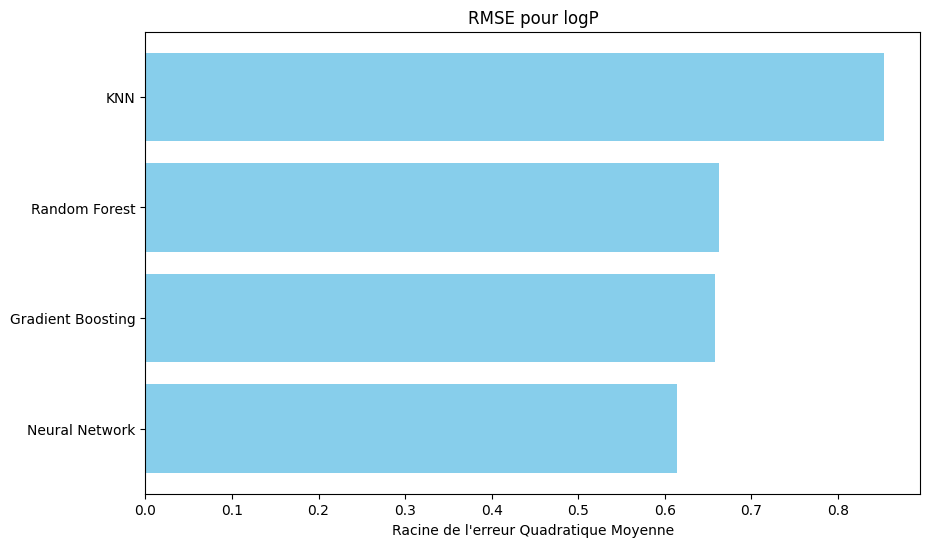

In [20]:
# Results visualization for rmse pIC50, logP.
plot_results(results_pic50_rmse, "RMSE pour pic50", "Racine de l'erreur Quadratique Moyenne")
plot_results(results_logP_rmse, "RMSE pour logP", "Racine de l'erreur Quadratique Moyenne")

* ### Mean Absolute Error (MAE)

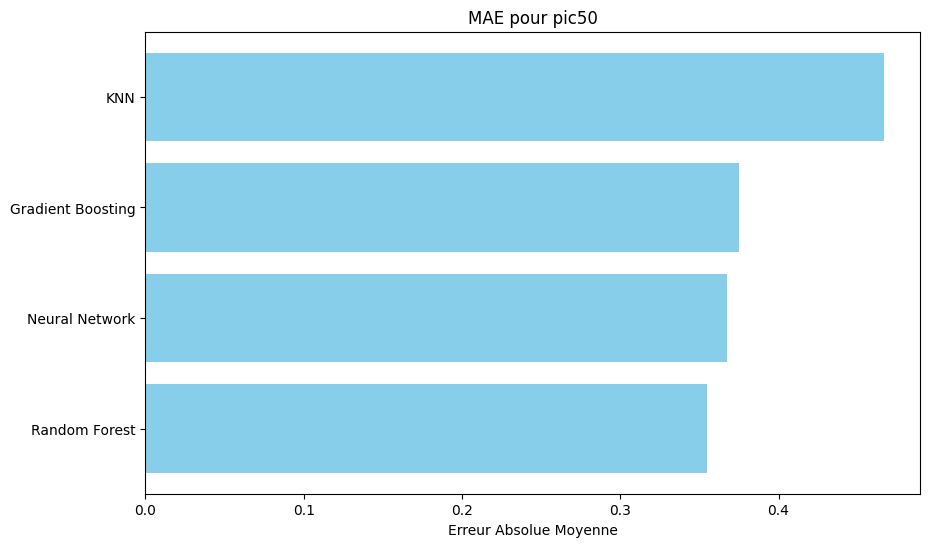

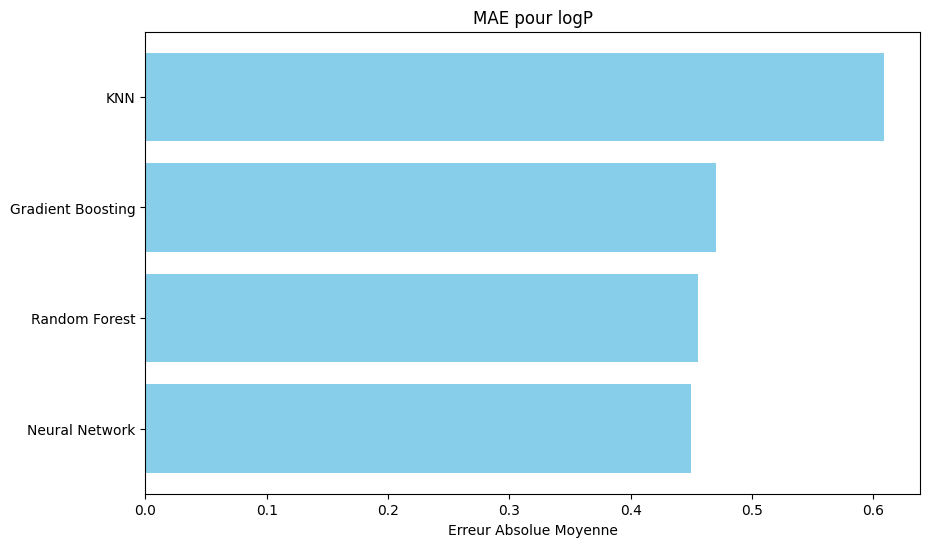

In [21]:
# Results visualization for mae pIC50, logP.
plot_results(results_pic50_mae, "MAE pour pic50", "Erreur Absolue Moyenne")
plot_results(results_logP_mae, "MAE pour logP", "Erreur Absolue Moyenne")

* ### Mean Absolute Percentage Error (MAPE)

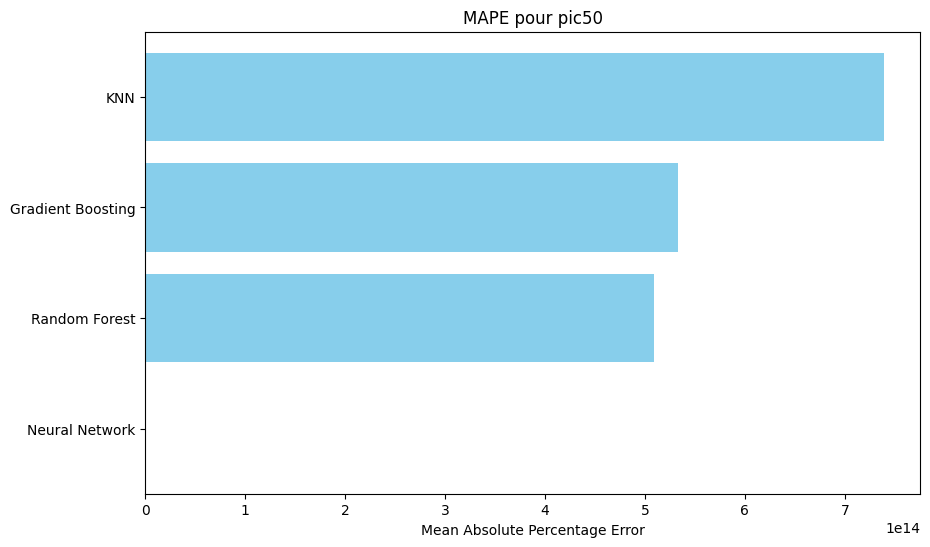

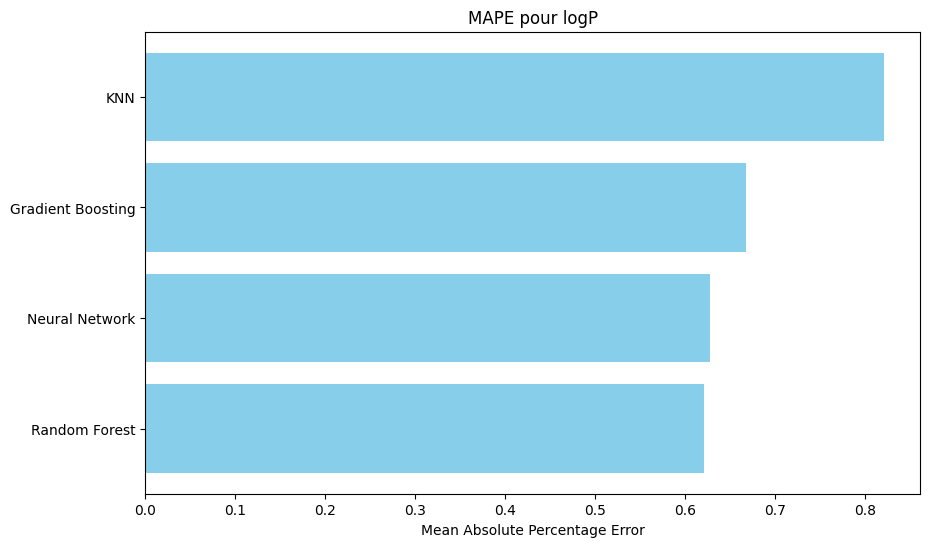

In [22]:
# Results visualization for mape pIC50, logP.
plot_results(results_pic50_mape, "MAPE pour pic50", "Mean Absolute Percentage Error")
plot_results(results_logP_mape, "MAPE pour logP", "Mean Absolute Percentage Error")

---

In [23]:
# Visualize training processes for all models (pIC50)
# plot_multiple_training_processes(training_losses_pic50, validation_losses_pic50)


In [24]:
# Visualize training processes for all models (logP)
# plot_multiple_training_processes(training_losses_logP, validation_losses_logP)
